In [29]:
import numpy as np
from numpy.linalg import norm
import networkx as nx
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from scipy.linalg import eig
import string
from sklearn.decomposition import PCA

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Q2

## Order of faces using ISOMAP

This question aims to reproduce the ISOMAP algorithm results in the original paper for
ISOMAP, J.B. Tenenbaum, V. de Silva, and J.C. Langford, Science 290 (2000) 2319-2323
that we have also seen in the lecture as an exercise (isn’t this exciting to go through the
process of generating results for a high-impact research paper!)
The file isomap.mat (or isomap.dat) contains 698 images, corresponding to different poses
of the same face. Each image is given as a 64 × 64 luminosity map, hence represented as a
vector in $\mathbb{R}^{4096}$  . This vector is stored as a row in the file. [This is one of the datasets used in
the original paper] In this question, you are expected to implement the ISOMAP algorithm
by coding it up yourself. You may use the provided functions in ShortestPath.zip to find the
shortest path as required by one step of the algorithm.
Choose the Euclidean distance (i.e., in this case, a distance in $\mathbb{R}^{4096}$ ) to construct the
nearest neighbor graph—vertices corresponding to the images. Construct a similarity graph
with vertices corresponding to the images, and tune the threshold $\epsilon$ so that each node has
at least 100 neighbors (this approach corresponds to the so-called $\epsilon$-Isomap).


1. Visualize the similarity graph (you can either show the adjacency matrix, or similar to the lecture slides, visualize the graph using graph visualization packages such as Gephi (https://gephi.org) and illustrate a few images corresponds to nodes at different parts of the graph, e.g., mark them by hand or use software packages).

In [2]:
#load data
data=loadmat('isomap.mat')['images'].T

In [3]:
#notate original shape of the images
original_shape = (64,64)

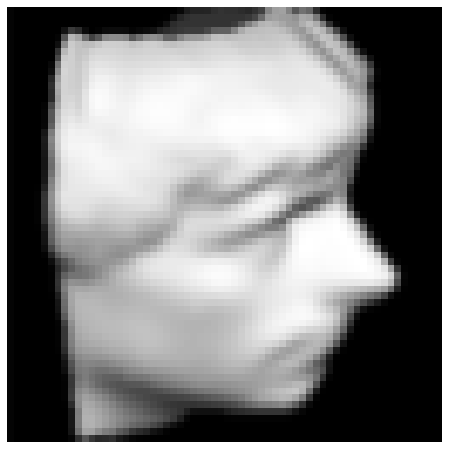

In [4]:
#visualize a single image in the dataset
plt.figure(figsize=(15,8))
plt.imshow(data[100,:].reshape(original_shape).T, cmap='gray')
plt.axis('off')
plt.show()

In [5]:
def Matrix_D(W):
    # Generate Graph and Obtain Matrix D, \\
    # from weight matrix W defining the weight on the edge between each pair of nodes.
    # Note that you can assign sufficiently large weights to non-existing edges.

    n = np.shape(W)[0]
    Graph = nx.DiGraph()
    for i in range(n):
        for j in range(n):
            Graph.add_weighted_edges_from([(i,j,min(W[i,j], W[j,i]))])

    res = dict(nx.all_pairs_dijkstra_path_length(Graph))
    D = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            D[i,j] = res[i][j]
    np.savetxt('D.csv', D)
    return D

In [6]:
def wnn(data, epsilon=None, n_neighbors=None, distance='eucl'):
    '''
    This function calculates the adjacency matrix by one of two methods. If n_neighbors is 
    None, then epsilon-isomap is calculated (threshold by epsilon). User must manually tune
    epsilon until an adjacency matrix is produced such that each node has a minimum of n-desired
    neighbors. If n_neighbors is supplied, epsilon is ignored and the adjacency for a given node 
    will continue to be calculated until it has n_neighbors
    '''
    m = data.shape[0]
    
    #if n_neighbors not supplied perform epsilon-isomap
    if not n_neighbors:
        
        #initialize emptry array to store results
        A = np.zeros(shape=(m,m))

        #loop through each row
        for i in range(m):
            for j in range(i,m):

                a = data[i]
                b = data[j]
                
                #calculation for euclidian distance
                if distance == 'eucl':
                    dist = np.sqrt(sum((a - b)**2))
                    
                #calculation for manhattan distance
                elif distance == 'manhattan':
                    dist = np.sum(np.abs(a-b)**1)**(1/1)
                
                #panic 
                else:
                    return 'Invalid distance metric'
                
                #if distance is less than epsilon record the neighbors as an undirected graph
                if dist <= epsilon:
                    A[i][j] = dist
                    A[j][i] = dist

        return A
    
    #if n_neighbors provided, calculate distance for a given node until it has n_neighbors
    else:
        
        #calculate the distance of all nodes from all other nodes
        dist = np.array([[norm(a-b) for b in data] for a in data])
        
        #initialize empty array to hold results
        A= np.zeros((m,m))
        
        #sort in decreasing order and slice by the first n neighbors
        sorted_ = np.argsort(dist, axis=1)[:, 1:n_neighbors+1]
        
        #record the distances for the first 100 neighbors for each row
        for pos, x in enumerate(sorted_):
            A[pos, x] = dist[pos, x]
            
        return A
    

In [7]:
#epsilon to produce at least 100 neighbors was found to be 22.38

#calculte k-nearest neighbors with k=100
A_knn = wnn(data=data, n_neighbors=100)

#find epsilon nearest neighbors with epsilon ensuring a min of 100 neighbors
A_eps = wnn(data=data, epsilon=22.38, n_neighbors=None)

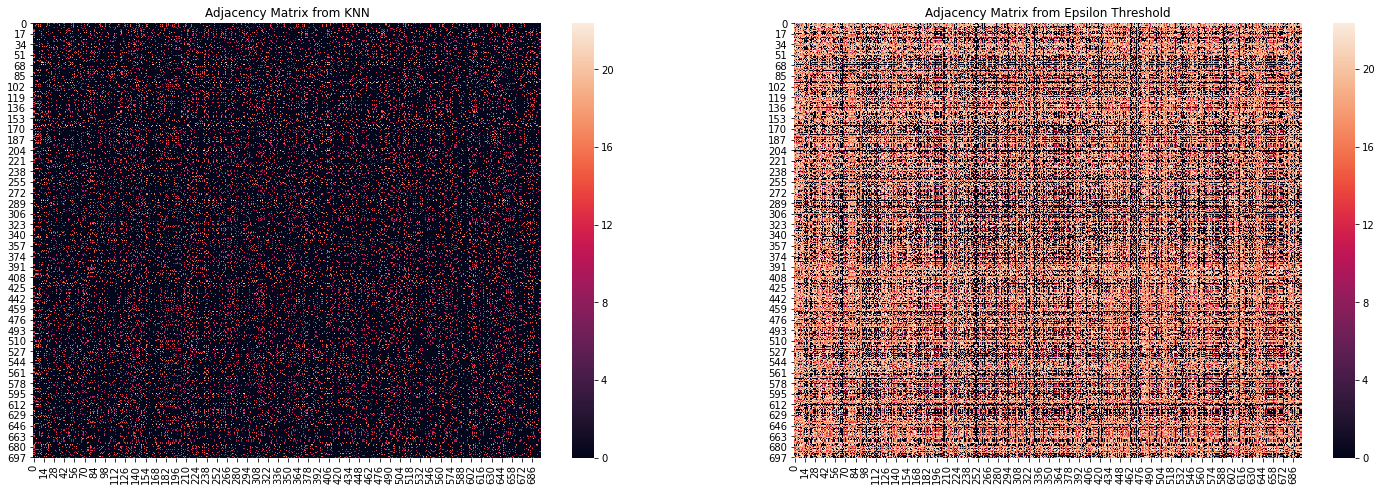

In [8]:
plt.subplots(nrows=1, ncols=2, figsize=(25,8))
plt.subplot(121)
sns.heatmap(A_knn)
plt.title('Adjacency Matrix from KNN')

plt.subplot(122)
sns.heatmap(A_eps)
plt.title('Adjacency Matrix from Epsilon Threshold')
plt.show()

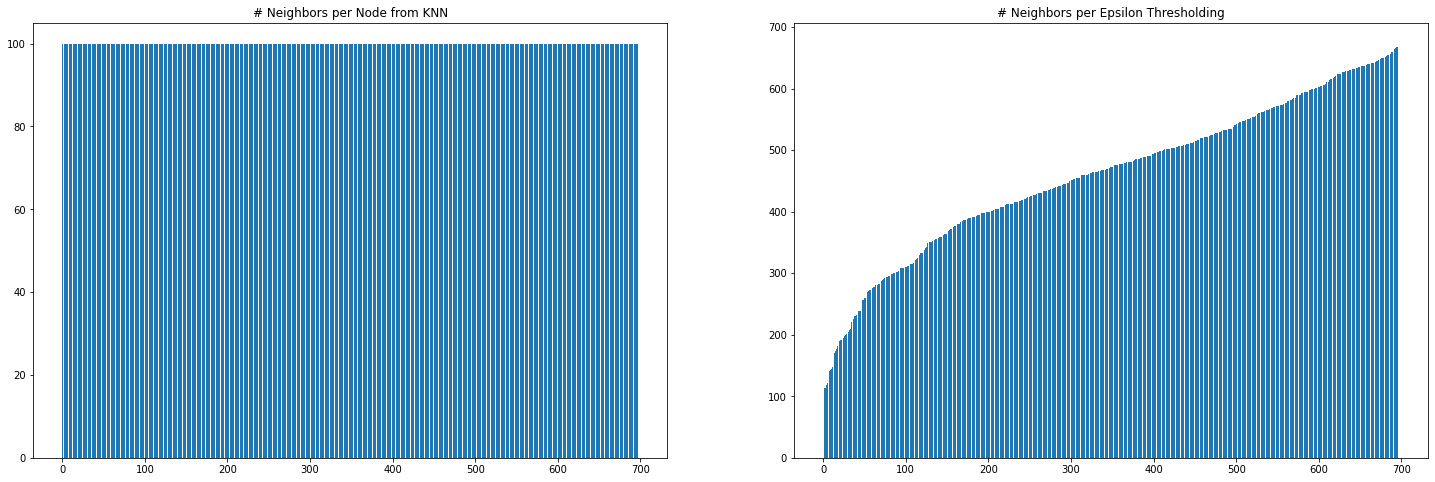

In [9]:
plt.subplots(nrows=1, ncols=2, figsize=(25,8))
d = sorted([x[x != 0].shape[0] for x in A_knn])
plt.subplot(121)
plt.bar(range(A_knn.shape[0]), d)
plt.title('# Neighbors per Node from KNN')


d = sorted([x[x != 0].shape[0] for x in A_eps])
plt.subplot(122)
plt.bar(range(A_knn.shape[0]), d)
plt.title('# Neighbors per Epsilon Thresholding')
plt.show()

In [10]:
'''
This code was used to generate the actual graph with nodes and edges.
Wasn't a fan of how it turned out nor the runtime. Keeping code for future
reference, but not outputing the graph for the final report 
'''

# b = A.copy()
# b[b == np.inf] =0

# G = nx.from_numpy_array(b)

# dt = [('len', float)]

# b = b.view(dt)

# G = nx.from_numpy_matrix(b)
# G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())),string.ascii_uppercase)))    

# G = nx.drawing.nx_agraph.to_agraph(G,)

# G.node_attr.update(color="red", style="filled", height="1", width="1")
# G.edge_attr.update(color="black", weight="2.0")

# G.draw('distances.png', format='png', prog='neato', args='-Goutputorder=edgesfirst')

"\nThis code was used to generate the actual graph with nodes and edges.\nWasn't a fan of how it turned out nor the runtime. Keeping code for future\nreference, but not outputing the graph for the final report \n"

2. Implement the ISOMAP algorithm yourself to obtain a k = 2-dimensional embedding. This means, each picture is represented by a two-dimensional vector (Z in the lecture), which we called “embedding” of pictures. Plot the embeddings using a scatter plot, similar to the plots in lecture slides. Find a few images in the embedding space and show what these images look like. Comment on do you see any visual similarity among them and their arrangement, similar to what you seen in the paper?

In [11]:
#prep data to calculate D matrix
a_knn = A_knn.copy()
a_eps = A_eps.copy()

#map distances in the Adj. Graph of 0 to infinity before calculating D
a_knn[a_knn==0] = np.inf
a_eps[a_eps==0] = np.inf

#calculate D matrix for both methods
D_knn = Matrix_D(a_knn)
D_eps = Matrix_D(a_eps)

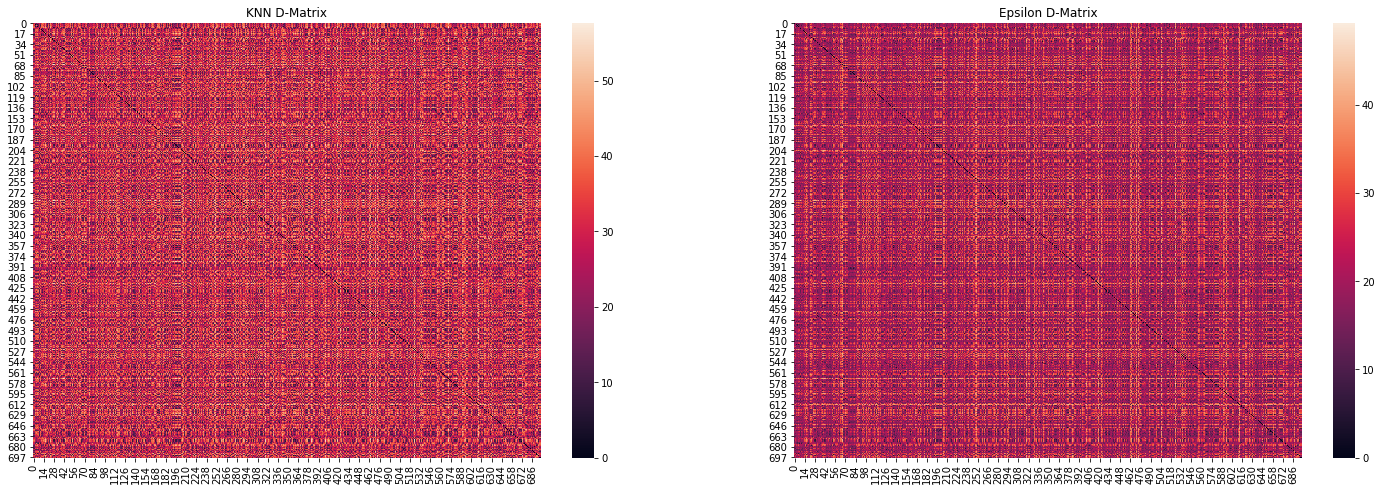

In [12]:
plt.subplots(nrows=1, ncols=2, figsize=(25,8))
plt.subplot(121)
sns.heatmap(D_knn)
plt.title('KNN D-Matrix')

plt.subplot(122)
sns.heatmap(D_eps)
plt.title('Epsilon D-Matrix')
plt.show()

In [13]:
def center(D):
    I = np.eye(A_knn.shape[0])
    ones = np.ones((D.shape[0], 1))
    m = D.shape[0]
    
    H = I - (1/m)* ones.dot(ones.T)
    
    return -0.5 * H.dot(D**2).dot(H)

In [14]:
C_knn = center(D_knn)
C_eps = center(D_eps)

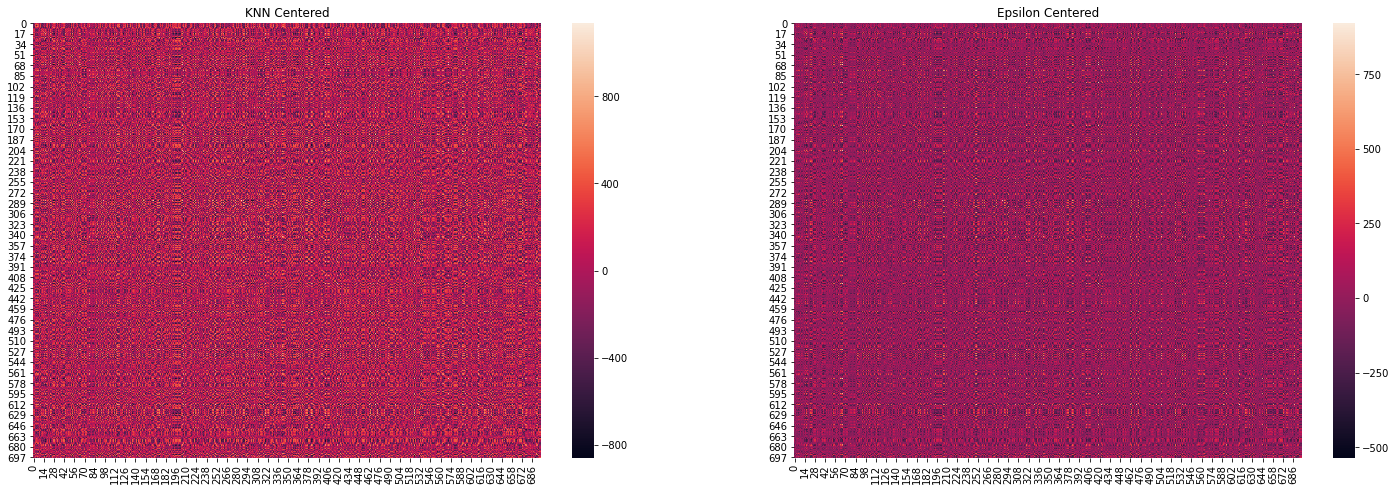

In [15]:
plt.subplots(nrows=1, ncols=2, figsize=(25,8))
plt.subplot(121)
sns.heatmap(C_knn)
plt.title('KNN Centered')

plt.subplot(122)
sns.heatmap(C_eps)
plt.title('Epsilon Centered')
plt.show()

In [16]:
def eigendecomposition(data: np.array, k: int) -> np.array:

    #eigendecomposition
    vals, vecs = np.linalg.eig(data)
    
    #pair vals with vecs before sorting
    vals_and_vecs = list( zip( np.abs(vals) , vecs.T ) )
    


    # Select n_components eigenvectors with largest eigenvalues, obtain subspace transform matrix
    vals_and_vecs.sort(key=lambda x: x[0], reverse=True)
    vals_and_vecs = np.array(vals_and_vecs)
    W = np.hstack([vals_and_vecs[i, 1].reshape(data.shape[1], 1) for i in range(k)])

    # Return samples in new subspace
    return np.real(vals[:k]), np.real(W)


def isomap(data: np.array, k: int) -> np.array:
    
    #eigendecomposition
    vals, vecs = eigendecomposition(data, k)
    
    #sqrt and diagonalize the eigenvalues
    vals = np.diag(np.sqrt(vals))
    
    #return the dot product between eigenvectors and eigenvalues
    return vecs.dot(vals)



def pca(data: np.array, k: int) -> np.array:
    
    #calculate the mean of each column
    mu = np.mean(data, axis=0)

    #mean ceter the values
    centered = (data - mu)

    #calculate covariance matrix
    cov = centered.T.dot(centered)

    
    #eigendecomposition
    vals, vecs = eigendecomposition(cov, k)
    
    return centered.dot(vecs)

In [17]:
#calculate isomap for knn
isomap_knn = isomap(C_knn, 2)

#calculate isomap for epsilon
isomap_eps = isomap(C_eps, 2)

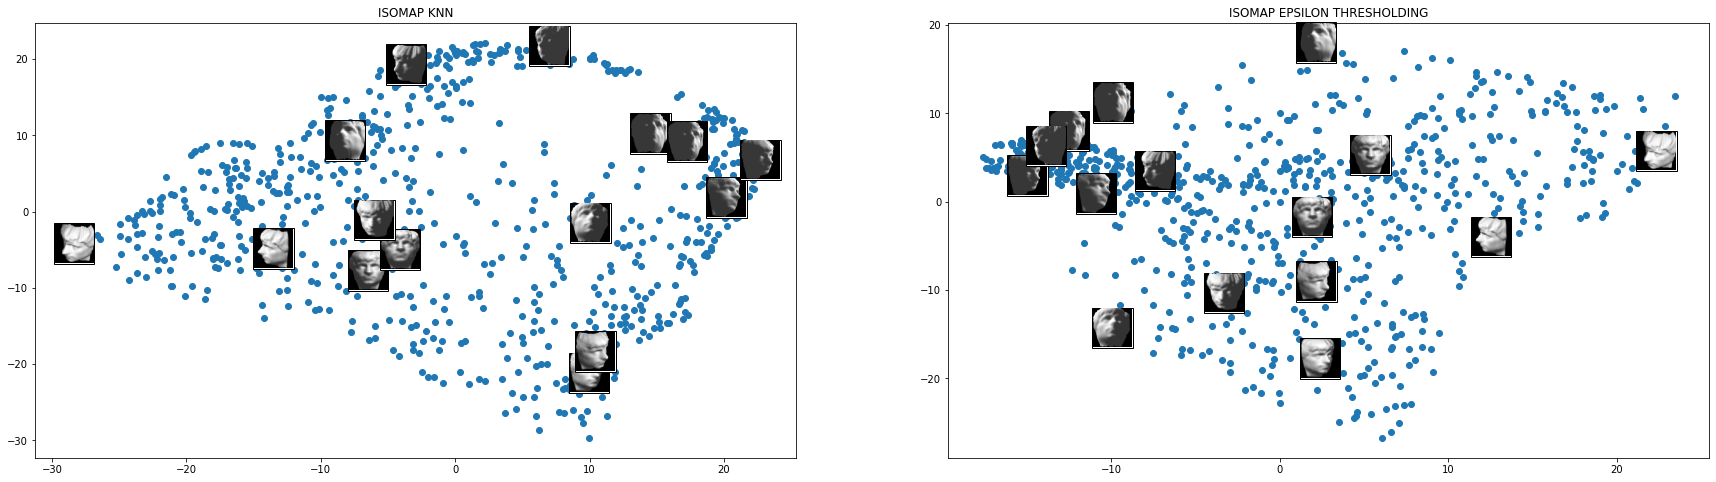

In [18]:
selected_image_idx  = [323, 399, 402, 56, 85,167, 364, 299, 253, 10, 416, 439 , 29, 49, 494]
#[16,559, 250, 352, 204, 90, 500, 199, 396, 689, 487, 56, 555, 452,332, 174, 123, 156, 178, 270, 406, 119, 186, 249, 474, 70, 14,583, 261, 395, 46, 316, 184, 562, 533, 471, 35, 147, 668, 612, 618, 133,231,522,281,454,613]


plt.subplots(nrows=1, ncols=2, figsize=(30,8))
ax=plt.subplot(121)
ax.scatter(isomap_knn[:,0], isomap_knn[:,1])
plt.title('ISOMAP KNN')
for i in selected_image_idx:
    single_image = data[i,:].reshape(64, 64).T

    imagebox = OffsetImage(single_image, zoom=0.6, cmap='gray')
    ab = AnnotationBbox(imagebox, isomap_knn[i], pad=0.1)
    ax.add_artist(ab)  


ax=plt.subplot(122)
ax.scatter(isomap_eps[:,0], isomap_eps[:,1])
plt.title('ISOMAP EPSILON THRESHOLDING')
for i in selected_image_idx:
    single_image = data[i,:].reshape(64, 64).T

    imagebox = OffsetImage(single_image, zoom=0.6, cmap='gray')
    ab = AnnotationBbox(imagebox, isomap_eps[i], pad=0.1)
    ax.add_artist(ab)  

plt.show()



3. Now choose L1 distance (or Manhattan distance) between images (recall the definition from “Clustering” lecture)). Repeat the steps above. Use $\epsilon$-ISOMAP to obtain a k = 2 dimensional embedding. Present a plot of this embedding. Do you see any difference by choosing a different similarity measure by comparing results in Part (b) and Part (c)?

In [19]:
A_knn = wnn(data=data, n_neighbors=100, distance='manhattan')
A_eps = wnn(data=data, epsilon=1011,  distance='manhattan')

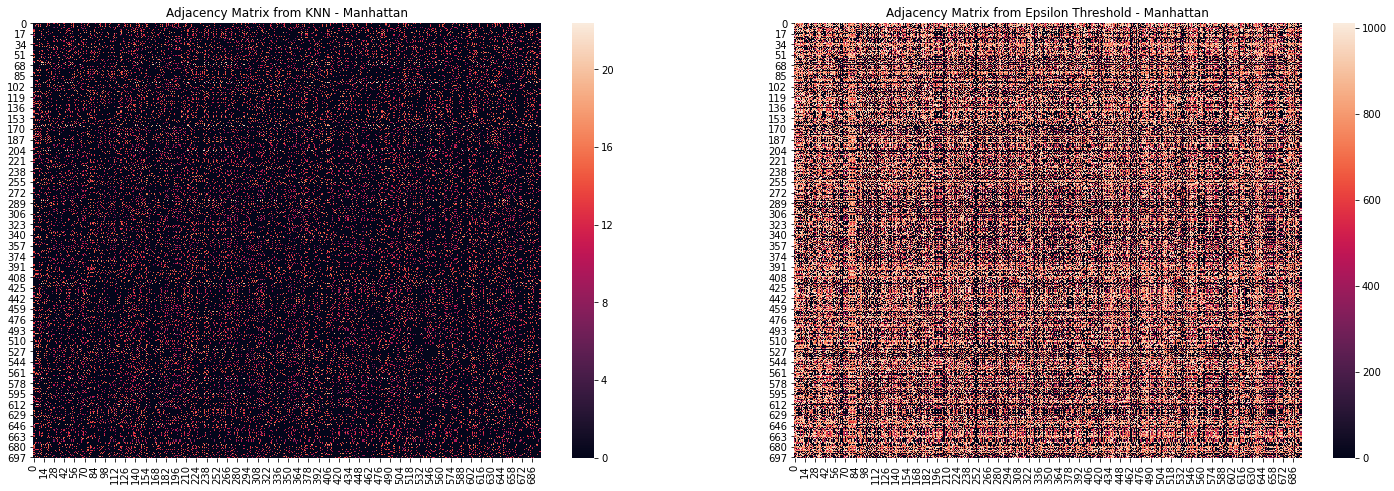

In [20]:
plt.subplots(nrows=1, ncols=2, figsize=(25,8))
plt.subplot(121)
sns.heatmap(A_knn)
plt.title('Adjacency Matrix from KNN - Manhattan')

plt.subplot(122)
sns.heatmap(A_eps)
plt.title('Adjacency Matrix from Epsilon Threshold - Manhattan')
plt.show()

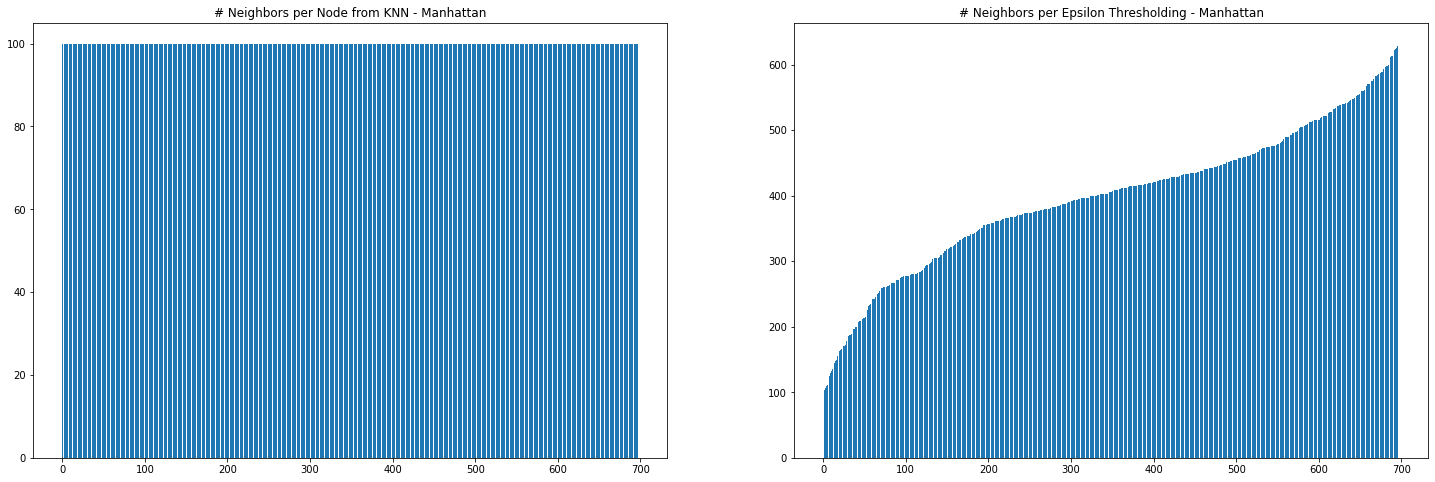

In [21]:
plt.subplots(nrows=1, ncols=2, figsize=(25,8))
d = sorted([x[x != 0].shape[0] for x in A_knn])
plt.subplot(121)
plt.bar(range(A_eps.shape[0]), d)
plt.title('# Neighbors per Node from KNN - Manhattan')


d = sorted([x[x != 0].shape[0] for x in A_eps])
plt.subplot(122)
plt.bar(range(A_eps.shape[0]), d)
plt.title('# Neighbors per Epsilon Thresholding - Manhattan')
plt.show()

In [22]:
#prep data to calculate D matrix
a_knn = A_knn.copy()
a_eps = A_eps.copy()

#map distances in the Adj. Graph of 0 to infinity before calculating D
a_knn[a_knn==0] = np.inf
a_eps[a_eps==0] = np.inf

#calculate D matrix for both methods
D_knn = Matrix_D(a_knn)
D_eps = Matrix_D(a_eps)

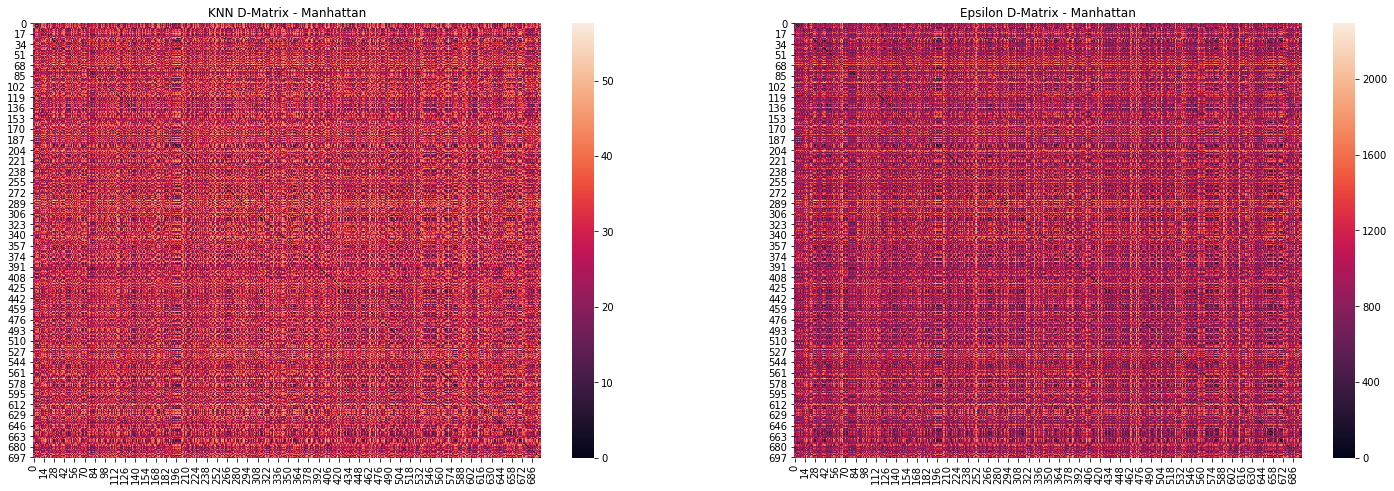

In [23]:
plt.subplots(nrows=1, ncols=2, figsize=(25,8))
plt.subplot(121)
sns.heatmap(D_knn)
plt.title('KNN D-Matrix - Manhattan')

plt.subplot(122)
sns.heatmap(D_eps)
plt.title('Epsilon D-Matrix - Manhattan')
plt.show()

In [24]:
C_knn = center(D_knn)
C_eps = center(D_eps)

In [25]:
#calculate isomap for knn
isomap_knn = isomap(C_knn, 2)

#calculate isomap for epsilon
isomap_eps = isomap(C_eps, 2)

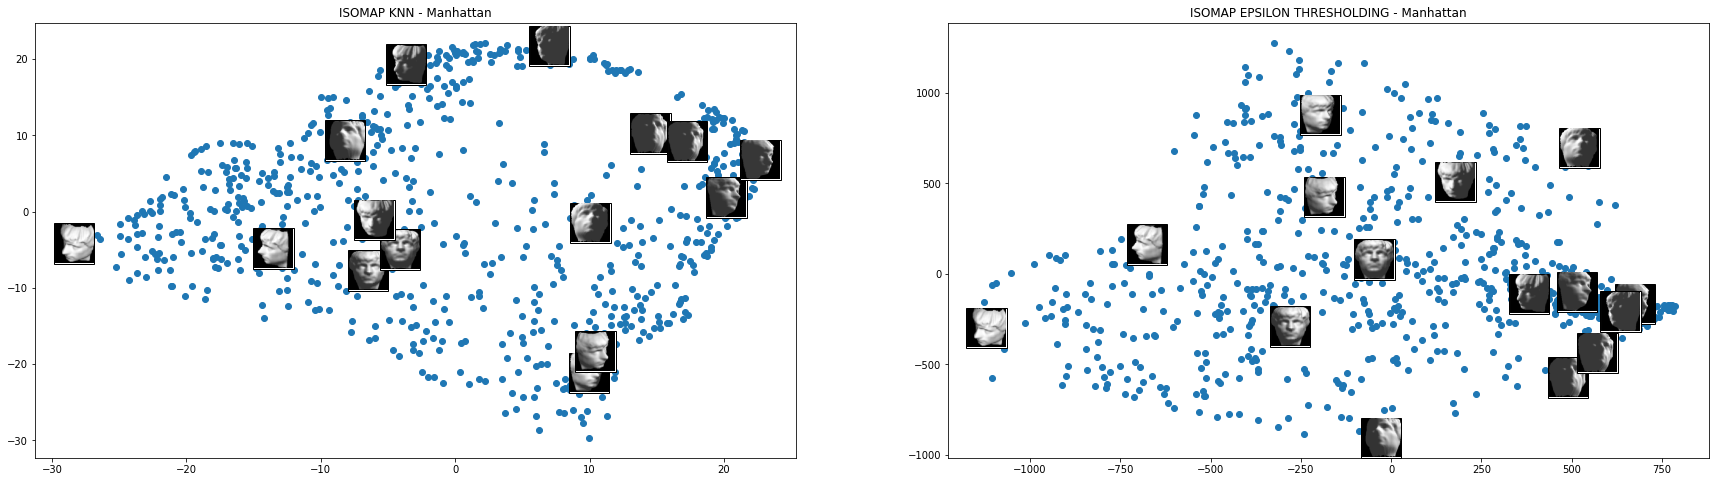

In [26]:
selected_image_idx = [323, 399, 402, 56, 85,167, 364, 299, 253, 10, 416, 439 , 29, 49, 494]
#[16,559, 250, 352, 204, 90, 500, 199, 396, 689, 487, 56, 555, 452,332, 174, 123, 156, 178, 270, 406, 119, 186, 249, 474, 70, 14,583, 261, 395, 46, 316, 184, 562, 533, 471, 35, 147, 668, 612, 618, 133,231,522,281,454,613]


plt.subplots(nrows=1, ncols=2, figsize=(30,8))
ax=plt.subplot(121)
ax.scatter(isomap_knn[:,0], isomap_knn[:,1])
plt.title('ISOMAP KNN - Manhattan')
for i in selected_image_idx:
    single_image = data[i,:].reshape(64, 64).T

    imagebox = OffsetImage(single_image, zoom=0.6, cmap='gray')
    ab = AnnotationBbox(imagebox, isomap_knn[i], pad=0.1)
    ax.add_artist(ab)  


ax=plt.subplot(122)
ax.scatter(isomap_eps[:,0], isomap_eps[:,1])
plt.title('ISOMAP EPSILON THRESHOLDING - Manhattan')
for i in selected_image_idx:
    single_image = data[i,:].reshape(64, 64).T

    imagebox = OffsetImage(single_image, zoom=0.6, cmap='gray')
    ab = AnnotationBbox(imagebox, isomap_eps[i], pad=0.1)
    ax.add_artist(ab)  

plt.show()



4. Perform PCA (you can now use your implementation written in Question
1) on the images and project them into the top 2 principal components. Again show them on a scatter plot. Explain whether or you see a more meaningful projection using ISOMAP than PCA.

In [46]:
#find epsilon nearest neighbors with epsilon ensuring a min of 100 neighbors
A_eps = wnn(data=data, epsilon=22.38, n_neighbors=None)

#prep data to calculate D matrix
a_eps = A_eps.copy()

#map distances in the Adj. Graph of 0 to infinity before calculating D
a_eps[a_eps==0] = np.inf

#calculate D matrix for both methods
D_eps = Matrix_D(a_eps)

#center
C_eps = center(D_eps)

pca_eps = PCA(n_components=2)
pca_eps.fit(C_eps)
pca_eps = pca_eps.transform(C_eps) / np.sqrt(pca_eps.singular_values_) * -1


#calculate isomap for epsilon
isomap_eps = isomap(C_eps, 2)
isomap_eps[:,0] = isomap_eps[:,0] *-1

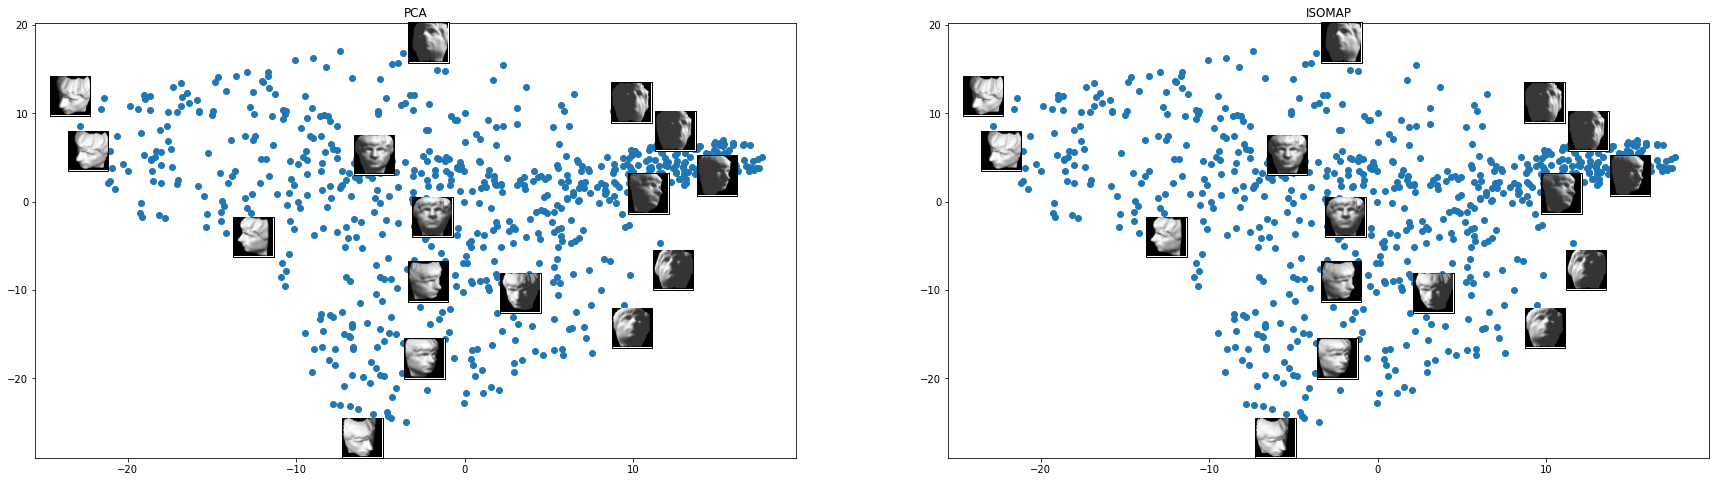

In [47]:
selected_image_idx = [323, 525, 399, 402, 56, 506, 85, 668,167, 364, 299, 253, 10, 416, 439 , 29]


plt.subplots(nrows=1, ncols=2, figsize=(30,8))
ax=plt.subplot(121)
ax.scatter(pca_eps[:,0], pca_eps[:,1])
plt.title('PCA')
for i in selected_image_idx:
    single_image = data[i,:].reshape(64, 64).T

    imagebox = OffsetImage(single_image, zoom=0.6, cmap='gray')
    ab = AnnotationBbox(imagebox, pca_eps[i], pad=0.1)
    ax.add_artist(ab)  


ax=plt.subplot(122)
ax.scatter(isomap_eps[:,0], isomap_eps[:,1])
plt.title('ISOMAP')
for i in selected_image_idx:
    single_image = data[i,:].reshape(64, 64).T

    imagebox = OffsetImage(single_image, zoom=0.6, cmap='gray')
    ab = AnnotationBbox(imagebox, isomap_eps[i], pad=0.1)
    ax.add_artist(ab)  

plt.show()